<a href="https://colab.research.google.com/github/SD325/NASA_Internship_2020/blob/master/NASA_Data_Preparation_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
# Imports
import pickle
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load Data

In [3]:
import scipy.io
BASE_DIR = '/content/drive/My Drive/data/NASA_2020/'
# fall, winter, spring, summer
filenames =['colloc_Precipflag_DPR_GMI_20151007.sav',
            'colloc_Precipflag_DPR_GMI_20160113.sav',
            'colloc_Precipflag_DPR_GMI_20160401.sav']
            #,'colloc_Precipflag_DPR_GMI_20170606.sav']
FILE_PATHS = [BASE_DIR + fn for fn in filenames]
data = [scipy.io.readsav(filepath, verbose=1) for filepath in FILE_PATHS]

--------------------------------------------------
Date: Sat Jun 27 00:49:52 2020
User: jgong
Host: gs613-cirrus.ndc.nasa.gov
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.7.3
--------------------------------------------------
Successfully read 14 records of which:
 - 11 are of type VARIABLE
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - tc [<class 'numpy.ndarray'>]
 - latc [<class 'numpy.ndarray'>]
 - lonc [<class 'numpy.ndarray'>]
 - utc [<class 'numpy.ndarray'>]
 - emis [<class 'numpy.ndarray'>]
 - emis_std [<class 'numpy.ndarray'>]
 - ts [<class 'numpy.ndarray'>]
 - clwp [<class 'numpy.ndarray'>]
 - twv [<class 'numpy.ndarray'>]
 - tysfc [<class 'numpy.ndarray'>]
 - pflag [<class 'numpy.ndarray'>]
--------------------------------------------------
--------------------------------------------------
Date: Fri Jun 26 15:53:36 2020


* *nch* = 13 (number of channels. For channel frequency:
https://www.star.nesdis.noaa.gov/mirs/gpmgmi.php)
* *nfov* = 221 
* *nrec*: number of sweep scans for each particular day

## Variables

* **Emis**: surface emissivity, [no unit], dimension [nch*nfov *nrec]. Valid value: 0<Emis<1
* **Emis_std**: standard deviation of surface emissivity, same dimension with Emis; can be used as a quality-control for "Emis". If Emis_std is large relative to Emis value, that indicates the emissivity data might be of doubtable quality.
* **Tysfc**: surface type. Integer number, each number represents one type of surface (e.g., 1 is ocean). The value of this number has no physical meaning. Rather, it should be served as a classifier for surface. Dimension [nfov * nrec], valid value: 1,2,3, ...,13,14
* **Latc/lonc**: latitude/longitude. Unit is [degree], dimension [nfov * nrec].
* **UTC**: universal time in [hr] unit. Dimension is [nrec]. UTC is the same for each sweep (i.e., nfov).
* **Ts**: surface skin temperature. Unit [K]. dimension [nfov * nrec]. This number is only positive over land. 
* **TWV**: total column water vapor. Unit [??], dimension [nfov * nrec], valid value: [0,100]
* **CLWP**: cloud liquid water path. Unit [kg/m^2], dimension [nfov * nrec], valid value: [0, 12]
* **Tc**: brightness temperature. Unit [K], dimension [nch * nfov * nrec]. Valid value: [50-350]. This is the most important input that are purely from observations. We will try to see if we can solely rely on this variable and of course latitude/longitude/time/season for the precipitation flag prediction. 
* **PFlag**: flag of the type of precipitation. Dimension [nfov * nrec], valid value [0,1,2,3], where 0 is no precipitation, 1 is stratiform, 2 is convective and 3 is other precipitation. 


In [4]:
for data_i in data:
  for var, arr in data_i.items():
    print(f"\t{var}: {arr.shape}")
  print("-"*30)

	tc: (47381, 221, 13)
	latc: (47381, 221)
	lonc: (47381, 221)
	utc: (47381,)
	emis: (47381, 221, 13)
	emis_std: (47381, 221, 13)
	ts: (47381, 221)
	clwp: (47381, 221)
	twv: (47381, 221)
	tysfc: (47381, 221)
	pflag: (47381, 221)
------------------------------
	tc: (47371, 221, 13)
	latc: (47371, 221)
	lonc: (47371, 221)
	utc: (47371,)
	emis: (47371, 221, 13)
	emis_std: (47371, 221, 13)
	ts: (47371, 221)
	clwp: (47371, 221)
	twv: (47371, 221)
	tysfc: (47371, 221)
	pflag: (47371, 221)
------------------------------
	tc: (47408, 221, 13)
	latc: (47408, 221)
	lonc: (47408, 221)
	utc: (47408,)
	emis: (47408, 221, 13)
	emis_std: (47408, 221, 13)
	ts: (47408, 221)
	clwp: (47408, 221)
	twv: (47408, 221)
	tysfc: (47408, 221)
	pflag: (47408, 221)
------------------------------


[0.38111112 0.38166666 0.38222224 ... 1.0569444  1.0575     1.0580555 ]


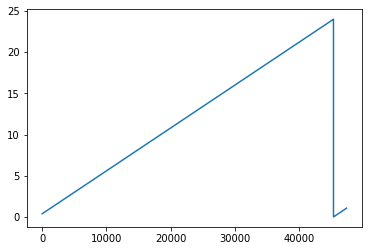

In [5]:
# plot of scan times --> drop due to reset after midnight
print(data[0]['utc'][1:])
plt.plot(range(np.size(data[0]['utc'][1:])), data[0]['utc'][1:])
plt.show()

# Trim Data

In [6]:
print(np.where(np.sum((data[0]['latc'] == -9999.900390625), axis=0) != 0)[0], end='\n-----\n')
print(np.where(np.sum((data[1]['latc'] == -9999.900390625), axis=0) != 0)[0], end='\n-----\n')
print(np.where(np.sum((data[2]['latc'] == -9999.900390625), axis=0) != 0)[0], end='\n-----\n')
# print(np.where(np.sum((data[3]['latc'] == -9999.900390625), axis=0) != 0)[0], end='\n-----\n')

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220]
-----
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220]
-----
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220]
-----


In [7]:
print(data[0]['latc'][1:, 25:196])

[[-68.79434  -68.73609  -68.71694  ... -61.325665 -61.315002 -61.267876]
 [-68.781494 -68.72291  -68.70354  ... -61.31542  -61.304935 -61.25805 ]
 [-68.768    -68.709145 -68.689545 ... -61.304684 -61.294384 -61.2478  ]
 ...
 [-68.83302  -68.77591  -68.75754  ... -61.359344 -61.348076 -61.300156]
 [-68.82227  -68.76473  -68.746124 ... -61.350723 -61.339638 -61.292034]
 [-68.81102  -68.75305  -68.73422  ... -61.341705 -61.3308   -61.283375]]


In [8]:
import copy
data_trimmed = []
for i, data_i in enumerate(data):
  data_trimmed_i = {}
  for var, arr in data_i.items():
    if arr.ndim == 1:
      data_trimmed_i[var] = arr[1:] 
    else:
      data_trimmed_i[var] = arr[1:, 25:196] if arr.ndim == 2 else arr[1:, 25:196, :] 

  for var, arr in data_trimmed_i.items():
    print(f"{var}: {arr.shape}")
  print('-' * 15)
  data_trimmed.append(data_trimmed_i)

# free up memory
del data

tc: (47380, 171, 13)
latc: (47380, 171)
lonc: (47380, 171)
utc: (47380,)
emis: (47380, 171, 13)
emis_std: (47380, 171, 13)
ts: (47380, 171)
clwp: (47380, 171)
twv: (47380, 171)
tysfc: (47380, 171)
pflag: (47380, 171)
---------------
tc: (47370, 171, 13)
latc: (47370, 171)
lonc: (47370, 171)
utc: (47370,)
emis: (47370, 171, 13)
emis_std: (47370, 171, 13)
ts: (47370, 171)
clwp: (47370, 171)
twv: (47370, 171)
tysfc: (47370, 171)
pflag: (47370, 171)
---------------
tc: (47407, 171, 13)
latc: (47407, 171)
lonc: (47407, 171)
utc: (47407,)
emis: (47407, 171, 13)
emis_std: (47407, 171, 13)
ts: (47407, 171)
clwp: (47407, 171)
twv: (47407, 171)
tysfc: (47407, 171)
pflag: (47407, 171)
---------------


# Polarization Differences (PDs)

In [9]:
# calculate polarization differences (PD)
def add_to_PD_i(i, freq, ind1, ind2, data):
  PD[i][freq] = data[i]['tc'][:, :, ind1] - data[i]['tc'][:, :, ind2]

PD = [{} for _ in range(len(data_trimmed))]
for i in range(len(data_trimmed)):
  add_to_PD_i(i, '10.65', 0, 1, data_trimmed)
  add_to_PD_i(i, '18.70', 2, 3, data_trimmed)
  add_to_PD_i(i, '36.50', 5, 6, data_trimmed)
  add_to_PD_i(i, '89.00', 7, 8, data_trimmed)
  add_to_PD_i(i, '166.0', 9, 10, data_trimmed)
  print(PD[i].keys())

dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])
dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])
dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])


# Construct DataFrame

In [10]:
# # append ravelled data
# ravelled = {}
# for i, data_i in enumerate(data_trimmed):
#   for var, arr in data_i.items():
#     if np.ndim(arr) != 2
#     if i == 0:
#       ravelled[var] = np.ravel(arr)
#     else:
#       ravelled[var] = np.append(ravelled[var], np.ravel(arr))

# for var, arr in ravelled.items():
#     print(f"{var}: {arr.shape}")

In [11]:
data_dfs = [pd.DataFrame()] * len(data_trimmed)
data_dfs

[Empty DataFrame
 Columns: []
 Index: [], Empty DataFrame
 Columns: []
 Index: [], Empty DataFrame
 Columns: []
 Index: []]

In [10]:
# ravel 2d data --> scans one after another
'''
* 13 channels TB
* 3 channels PD (10.65, 89 and 166 GHz)
x Surface emissivity
* Ts
* CLWP
* TWV
* Lat/Lon
- Day of the year starting from the first day of the year (i.e., Julian day. For example, 1/1/2017 is 1, 2/1/2017 is 32)
'''
data_dfs = []
# data_df['pflag'] = np.ravel(data_trimmed['pflag'])
PD_freqs_append = ['10.65', '89.00', '166.0']
data_2d = {'latc': 'lat',
           'lonc': 'lon',
           'ts': 'ts',
           'clwp': 'clwp',
           'twv': 'twv'}
for i, data_i in enumerate(data_trimmed):
  curr_df = pd.DataFrame()
  # 2d data
  for data_name, df_name in data_2d.items():
    # print(f"\t{np.ravel(data_i[data_name]).shape}")
    curr_df[df_name] = np.ravel(data_i[data_name])

  # PDs
  for freq in PD_freqs_append:
    curr_df[f'PD_{freq}'] = np.ravel(PD[i][freq])

  # 3d data
  for idx in range(data_i['tc'].shape[2]):
    curr_df[f'tc_{idx}'] = np.ravel(data_i['tc'][:, :, idx])

  data_dfs.append(curr_df)
  del curr_df
  # print(f"{i}: {data_dfs[i].shape}")
  # print("0:")
  # print(data_dfs[0].head(), end='\n-----\n')
  # print("1:")
  # print(data_dfs[1].head(), end='\n-----\n')
  # data_df['tysfc'] = np.ravel(data_i['tysfc'])  # categorical --> add later!

print('combining DataFrames')
data_df = pd.concat(data_dfs, ignore_index = True)
del data_dfs
data_df.head()

combining DataFrames


,lat,lon,ts,clwp,twv,PD_10.65,PD_89.00,PD_166.0,tc_0,tc_1,tc_2,tc_3,tc_4,tc_5,tc_6,tc_7,tc_8,tc_9,tc_10,tc_11,tc_12
0,-68.794342,121.109978,-99.0,-99.0,-99.0,22.889999,14.330002,10.839996,228.770004,205.880005,223.490005,204.559998,222.809998,224.610001,208.850006,231.000000,216.669998,227.389999,216.550003,237.830002,230.470001
1,-68.736092,121.270271,-99.0,-99.0,-99.0,24.899994,13.979996,12.560013,229.369995,204.470001,222.880005,203.619995,223.070007,224.199997,208.869995,230.679993,216.699997,228.960007,216.399994,237.610001,231.130005
2,-68.716942,121.389320,-99.0,-99.0,-99.0,24.840012,14.509995,9.139999,228.990005,204.149994,223.880005,203.710007,223.369995,224.240005,208.160004,231.479996,216.970001,227.419998,218.279999,238.160004,231.839996
3,-68.697197,121.507530,-99.0,-99.0,-99.0,25.550003,14.410004,10.429993,228.979996,203.429993,223.240005,202.210007,222.839996,224.020004,205.979996,231.139999,216.729996,226.339996,215.910004,237.490005,231.080002
4,-68.648026,121.535782,-99.0,-99.0,-99.0,24.010010,14.319992,10.379990,228.630005,204.619995,223.919998,202.509995,222.520004,223.520004,206.960007,230.789993,216.470001,228.259995,217.880005,238.449997,231.389999


In [12]:
y = pd.DataFrame()
y['pflag'] = np.concatenate(tuple(np.ravel(data_trimmed[i]['pflag']).byteswap().newbyteorder() for i in range(len(data_trimmed))))
y.head()

,pflag
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [13]:
print(data_df.shape)
print(y.shape)

(24308847, 21)
(24308847, 1)


# Prepare Data

In [14]:
X_dropped = data_df[(~np.isnan(y['pflag'])) & (data_df['ts'] != -99.0) & (~np.isnan(data_df['twv']))]
X_dropped.head()

,lat,lon,ts,clwp,twv,PD_10.65,PD_89.00,PD_166.0,tc_0,tc_1,tc_2,tc_3,tc_4,tc_5,tc_6,tc_7,tc_8,tc_9,tc_10,tc_11,tc_12
405,-65.898605,125.724609,258.322540,0.011064,2.236660,29.500000,15.860001,7.970001,255.880005,226.380005,246.889999,221.880005,246.110001,244.300003,222.809998,235.240005,219.380005,229.220001,221.250000,246.289993,242.410004
406,-65.805023,125.751350,258.579742,0.014423,2.670216,29.080002,16.639999,8.400009,253.389999,224.309998,242.050003,215.660004,239.710007,241.649994,220.169998,236.690002,220.050003,230.100006,221.699997,246.559998,244.940002
407,-65.758141,125.762604,258.836304,0.017788,2.518587,30.960007,17.520004,9.369995,252.440002,221.479996,237.250000,211.589996,237.020004,238.259995,216.669998,236.710007,219.190002,231.639999,222.270004,246.270004,244.490005
408,-65.711205,125.772438,259.092346,0.021157,2.816634,31.970001,17.740005,8.839996,251.350006,219.380005,237.149994,211.309998,236.559998,239.070007,218.169998,236.779999,219.039993,232.750000,223.910004,245.880005,245.850006
409,-65.664230,125.780869,259.347931,0.024527,2.969014,28.739990,18.130005,9.139999,248.699997,219.960007,238.360001,211.179993,237.539993,239.399994,217.750000,238.830002,220.699997,234.940002,225.800003,245.990005,247.029999


In [15]:
print(y.shape)
y_dropped = y[(~np.isnan(y['pflag'])) & (data_df['ts'] != -99.0) & (~np.isnan(data_df['twv']))]
print(y_dropped.shape)

(24308847, 1)
(2185776, 1)


In [16]:
del data_df
del y

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_prep = scaler.fit_transform(X_dropped)
X_prep.shape

(2185776, 21)

In [18]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_prep = ohe.fit_transform(y_dropped).toarray()
y_prep.shape

(2185776, 4)

In [19]:
type(y_prep)

numpy.ndarray

In [20]:
# should be all zeros
print("X: ", sum(np.isnan(X_prep)))
print("y: ", sum(np.isnan(y_prep)))

X:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
y:  [0 0 0 0]


# Save Data

In [22]:
with open(BASE_DIR + 'X_data_3_days.pkl', 'wb') as f:
  pickle.dump(X_prep, f)

with open(BASE_DIR + 'y_data_3_days.pkl', 'wb') as f:
  pickle.dump(y_prep, f)